In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x59362000 @  0x7f6bbf98f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
0.4.1
True


We will code **Capsule Networks** in PyTorch. We will mainly be working with MNIST dataset only in this 

In [0]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms, datasets

In [3]:
import numpy as np

def one_hot_transform(labels):
    one_hot = torch.zeros(labels.size()+tuple([10])).scatter_(-1, labels, 1)
    return one_hot 
  
trainset = datasets.MNIST ( root='../data', train = True, download = True, transform = transforms.Compose([transforms.RandomCrop(28, 2), transforms.ToTensor(),]),
                            target_transform = one_hot_transform)

testset = datasets.MNIST ( root='../data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor(), ]),
                            target_transform = one_hot_transform)


train_loader = torch.utils.data.DataLoader( trainset, batch_size = 128, shuffle = True, num_workers = 4)

test_loader = torch.utils.data.DataLoader( testset, batch_size = 128, shuffle = False, num_workers = 4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Processing...
Done!


In [0]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations = 3):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)
      
    def softmax(self, tensor, dim = 1):
      transposed_input = tensor.transpose(dim, len(tensor.size()) - 1)
      softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
      return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(tensor.size()) - 1)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]
        
            logits = torch.zeros(*priors.size()).to(device)
            for i in range(self.num_iterations):
                probs = self.softmax(logits, dim = 2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)
        return outputs

In [0]:
class CapsuleNetDecoder(nn.Module):
    def __init__(self):
        super(CapsuleNetDecoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = 9, stride = 1)
        self.primary_capsules = CapsuleLayer(num_capsules = 8, num_route_nodes = -1, in_channels = 256, out_channels = 32,
                                             kernel_size = 9, stride = 2)
        self.digit_capsules = CapsuleLayer(num_capsules = 10, num_route_nodes = 32 * 6 * 6, in_channels = 8,
                                           out_channels = 16)

        self.decoder = nn.Sequential( nn.Linear(16 * 10, 512),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(512, 1024),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(1024, 784),
                                      nn.Sigmoid()
                                    )

    def forward(self, x, y, recons = True):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        reconstructions = None
        if (recons):
          reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))

        return x, classes, reconstructions

In [0]:
class CapsLoss(nn.Module):
  
    def __init__(self):
        super(CapsLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average = False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(0.9 - classes, inplace = True) ** 2
        right = F.relu(classes - 0.1, inplace = True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [11]:
import torch.optim as optim

criterion = CapsLoss()
net = CapsuleNetDecoder().to(device) #for GPU
optimizer = optim.Adam(net.parameters(), lr = 0.001)
start_epoch = 0

for epoch in range(15):  # fix num-epochs as 15.

    # training
    net.train()
    running_loss = 0.0
    count = 0.0
    for data in train_loader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x, outputs, reconst = net(inputs, labels)
        loss = criterion(inputs, labels, outputs, reconst)
        
        loss.backward()
        optimizer.step()

        # statistics
        running_loss +=  ( loss.item() * inputs.size(0)) #multiply by the batch size
        count += sum(np.argmax(labels.data.cpu().numpy(), 1) == np.argmax(outputs.data.cpu().numpy(), 1)) #the accuracy
    
    print(" with recons epoch num: %d, Train loss: %.5f, Training Accuracy is: %.5f " % (epoch + 1, running_loss/len(trainset), count/len(trainset)) )
    
    # testing
    net.eval()
    running_loss = 0.0
    count = 0.0
    for data in test_loader:
        # get the inputs
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward 
        with torch.no_grad():
            x, outputs, reconst = net(inputs, labels)
        loss = criterion(inputs, labels, outputs, reconst)

        # statistics
        running_loss +=  ( loss.item() * inputs.size(0)) #multiply by the batch size
        count += sum(np.argmax(labels.data.cpu().numpy(), 1) == np.argmax(outputs.data.cpu().numpy(), 1)) #the accuracy
        
    print(" with recons epoch num: %d, Test loss: %.5f, Testing Accuracy is: %.5f " % (epoch + 1, running_loss/len(testset), count/len(testset)) )

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 with recons epoch num: 1, Train loss: 0.51934, Training Accuracy is: 0.89763 
 with recons epoch num: 1, Test loss: 0.47845, Testing Accuracy is: 0.98510 
 with recons epoch num: 2, Train loss: 0.48081, Training Accuracy is: 0.97863 
 with recons epoch num: 2, Test loss: 0.47313, Testing Accuracy is: 0.98980 
 with recons epoch num: 3, Train loss: 0.47529, Training Accuracy is: 0.98447 
 with recons epoch num: 3, Test loss: 0.47024, Testing Accuracy is: 0.99150 
 with recons epoch num: 4, Train loss: 0.47200, Training Accuracy is: 0.98652 
 with recons epoch num: 4, Test loss: 0.46794, Testing Accuracy is: 0.99250 
 with recons epoch num: 5, Train loss: 0.46983, Training Accuracy is: 0.98870 
 with recons epoch num: 5, Test loss: 0.46721, Testing Accuracy is: 0.99200 
 with recons epoch num: 6, Train loss: 0.46854, Training Accuracy is: 0.98955 
 with recons epoch num: 6, Test loss: 0.46569, Testing Accuracy is: 0.99390 
 with recons epoch num: 7, Train loss: 0.46733, Training Accurac

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f3daac645f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 155, in re

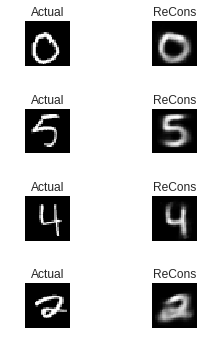

In [19]:
# now plot the actual data and reconstruction data. 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plot_loader = torch.utils.data.DataLoader( trainset, batch_size = 4, shuffle = True, num_workers = 4)

net.eval() #evaluating

for data in plot_loader:
  # get the inputs
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.to(device)
        
  # forward + backward + optimize
  x, outputs, reconst = net(inputs, labels)

  break #just take the 4 examples

X = np.asarray(inputs.data).astype(np.float32)

X_recons = np.asarray(reconst.data.view(-1,28,28)).astype(np.float32)


for i in range(X.shape[0]):
 
  plt.subplot(X.shape[0], 2, 2*i+1)
  plt.imshow(X[i][0], cmap = 'gray')
  plt.title('Actual')
  plt.axis('off')

  plt.subplot(X.shape[0], 2, 2*i+2)
  plt.imshow(X_recons[i], cmap = 'gray')
  plt.title("ReCons")
  plt.axis('off')
  
  #plt.subplots_adjust(wspace=0, hspace=0)
  plt.gcf().set_size_inches(5, 5)
  plt.tight_layout()
  
plt.show()

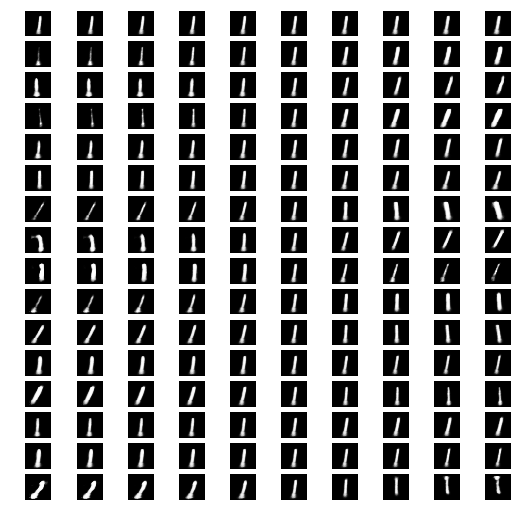

In [22]:
# now plot the reconstruction data with minor variations.

import copy

recons_loader = torch.utils.data.DataLoader( trainset, batch_size = 2, shuffle = True)

net.eval() #evaluating

for data in recons_loader:
  # get the inputs
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.to(device)
        
  # forward + backward + optimize
  x, _, _ = net(inputs, labels)
  x = (x * labels[:, :, None]).view(x.size(0), -1)
  
  break #just take the 1 example
  

l = ((labels[0] == 1).nonzero()) #for the label

# change it to all the 16 and 1 thing before sending than after sending.

X = x
for i in range(16): #representing the 16 dimension vector for each digits
  
  j = -0.25
  while (j < 0.25):
    temp = copy.deepcopy(x.data)
    temp[0][16 * l+ i] += j
    temp = temp[0].unsqueeze_(0)
   
    X = torch.cat((X,temp), dim = 0) 
    count += 1
    j += 0.05
  
X = X[2:, :] # removing the batch examples


X = net.decoder(X)
  
X = np.asarray(X.data.view(-1,28,28)).astype(np.float32)

for i in range(16):
  for j in range(10):
    plt.subplot(16, 10, (10 * i)+ j + 1)
    
    plt.imshow(X[10*i + j],cmap= 'gray')
    plt.axis('off')

  
    #plt.subplots_adjust(wspace=0, hspace=0)
    plt.gcf().set_size_inches(9, 9)
    #lt.tight_layout()
  
plt.show() 

In [23]:
# experiment without reconstruction

import torch.optim as optim

criterion = CapsLoss()
recons_net = CapsuleNetDecoder().to(device) #for GPU
optimizer = optim.Adam(recons_net.parameters(), lr = 0.001)
start_epoch = 0

for epoch in range(15):# fix num-epochs as 15.

    # training
    recons_net.train()
    running_loss = 0.0
    count = 0.0
    for data in train_loader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x, outputs, _ = recons_net(inputs, labels, False)
        loss = criterion(inputs, labels, outputs, inputs.view(inputs.shape[0], -1))
        
        loss.backward()
        optimizer.step()

        # statistics
        running_loss +=  ( loss.item() * inputs.size(0)) #multiply by the batch size
        count += sum(np.argmax(labels.data.cpu().numpy(), 1) == np.argmax(outputs.data.cpu().numpy(), 1)) #the accuracy
    
    print(" without recons epoch num: %d, Train loss: %.5f, Training Accuracy is: %.5f " % (epoch + 1, running_loss/len(trainset), count/len(trainset)) )
    
    # testing
    recons_net.eval()
    running_loss = 0.0
    count = 0.0
    for data in test_loader:
        # get the inputs
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward 
        with torch.no_grad():
            x, outputs, _ = recons_net(inputs, labels, False)
        loss = criterion(inputs, labels, outputs, inputs.view(inputs.shape[0], -1))

        # statistics
        running_loss +=  ( loss.item() * inputs.size(0)) #multiply by the batch size
        count += sum(np.argmax(labels.data.cpu().numpy(), 1) == np.argmax(outputs.data.cpu().numpy(), 1)) #the accuracy
        
    print(" without recons epoch num: %d, Test loss: %.5f, Testing Accuracy is: %.5f " % (epoch + 1, running_loss/len(testset), count/len(testset)) )

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 without recons epoch num: 1, Train loss: 0.49189, Training Accuracy is: 0.89522 
 without recons epoch num: 1, Test loss: 0.45881, Testing Accuracy is: 0.98340 
 without recons epoch num: 2, Train loss: 0.45845, Training Accuracy is: 0.97882 
 without recons epoch num: 2, Test loss: 0.45346, Testing Accuracy is: 0.99050 
 without recons epoch num: 3, Train loss: 0.45496, Training Accuracy is: 0.98490 
 without recons epoch num: 3, Test loss: 0.45219, Testing Accuracy is: 0.99060 
 without recons epoch num: 4, Train loss: 0.45341, Training Accuracy is: 0.98678 
 without recons epoch num: 4, Test loss: 0.45145, Testing Accuracy is: 0.99150 
 without recons epoch num: 5, Train loss: 0.45247, Training Accuracy is: 0.98848 
 without recons epoch num: 5, Test loss: 0.45086, Testing Accuracy is: 0.99270 
 without recons epoch num: 6, Train loss: 0.45184, Training Accuracy is: 0.98948 
 without recons epoch num: 6, Test loss: 0.45054, Testing Accuracy is: 0.99220 
 without recons epoch num: 7

#References

This code is taken from [this](https://github.com/gram-ai/capsule-networks) excellent repository and changes are made so that the reconstruction of images and the capsule dimension experiment is also performed. 